# Inputs

In [1]:
import os
import pandas as pd
import yaml

In [2]:
DATASET_PARAMS = yaml.load(open("configs/dataset.yaml"), Loader=yaml.SafeLoader)
PREPROCESSING_PARAMS = yaml.load(open("configs/preprocessing.yaml"), Loader=yaml.SafeLoader)
MODEL_NAME = yaml.load(open("configs/model.yaml"), Loader=yaml.SafeLoader)['MODEL_NAME']
MODEL_PARAMS = yaml.load(open("configs/model.yaml"), Loader=yaml.SafeLoader)[MODEL_NAME]
TRAINING_PARAMS = yaml.load(open("configs/training.yaml"), Loader=yaml.SafeLoader)

In [3]:
categories =  DATASET_PARAMS['CATEGORIES']

BASE_DIR = os.getcwd()
DATASET_DIR = os.path.join(BASE_DIR, DATASET_PARAMS['DATA_PATH'])

TRAIN_DIR = os.path.join(DATASET_DIR, "train")
VAL_DIR = os.path.join(DATASET_DIR, "val")
TEST_DIR = os.path.join(DATASET_DIR, "test")

In [4]:
from src.utils import get_device
DEVICE = get_device()
print(f"Using device: {DEVICE}")

Using device: cuda


# Dataset

In [5]:
from src.utils import generate_filenames_df

In [6]:
train_filenames_df = generate_filenames_df(TRAIN_DIR, 
                                           categories, 
                                           shuffle=True, 
                                           is_sample=DATASET_PARAMS['IS_SAMPLE'],
                                           sample_size=DATASET_PARAMS['SAMPLE_SIZE'],
                                           seed=42)

val_filenames_df = generate_filenames_df(VAL_DIR, 
                                         categories, 
                                         shuffle=True, 
                                         is_sample=DATASET_PARAMS['IS_SAMPLE'],
                                         sample_size=DATASET_PARAMS['SAMPLE_SIZE'],
                                         seed=42)

## Pre Processor

In [7]:
from src.preprocessing import preprocess

target_input_size = tuple(PREPROCESSING_PARAMS['INPUT_SIZE'])
train_transform = preprocess(
    target_input_size=target_input_size,
    rotation_range=PREPROCESSING_PARAMS['ROTATION_RANGE'],
    width_shift_range=PREPROCESSING_PARAMS['WIDTH_SHIFT_RANGE'],
    height_shift_range=PREPROCESSING_PARAMS['HEIGHT_SHIFT_RANGE'],
    brightness_range=PREPROCESSING_PARAMS['BRIGHTNESS_RANGE'],
    zoom_range=PREPROCESSING_PARAMS['ZOOM_RANGE'],
    horizontal_flip=PREPROCESSING_PARAMS['HORIZONTAL_FLIP'],
    vertical_flip=PREPROCESSING_PARAMS['VERTICAL_FLIP'],
    channel_shift_range=PREPROCESSING_PARAMS['CHANNEL_SHIFT_RANGE'],
    fill_mode=PREPROCESSING_PARAMS['FILL_MODE'],
    shear_range=PREPROCESSING_PARAMS['SHEAR_RANGE']
    )

val_transform = preprocess(target_input_size=target_input_size) # only rescaling

In [8]:
test_train_filenames_df =train_filenames_df.reset_index(drop=True).sample(frac=1, random_state=42).reset_index(drop=True)
train_filenames_df

,image_path,class
0,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,2
1,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,3
2,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,2
3,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,1
4,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,3
5,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,2
6,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,2
7,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,1
8,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,1
9,c:\Users\Yuno\Documents\Kuliah Sarjana\Project...,2


In [9]:
test_train_filenames_df.iloc[1000:]

,image_path,class


In [10]:
len(test_train_filenames_df[test_train_filenames_df['class'] == '1'])

13

In [11]:
from src.dataset import Dataset

train_dataset = Dataset(dataframe=train_filenames_df, 
                        categories=DATASET_PARAMS['CATEGORIES'],
                        transform=train_transform, 
                        seed=42, 
                        shuffle=TRAINING_PARAMS['SHUFFLE'])

val_dataset = Dataset(dataframe=val_filenames_df, 
                      categories=DATASET_PARAMS['CATEGORIES'],
                      transform=val_transform, 
                      seed=42, 
                      shuffle=TRAINING_PARAMS['SHUFFLE'])


## Train loader

In [12]:
from torch.utils.data import DataLoader

train_loader = DataLoader(train_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

val_loader = DataLoader(val_dataset, 
                          batch_size=TRAINING_PARAMS['BATCH_SIZE'], 
                          shuffle=False, 
                          num_workers=TRAINING_PARAMS['NUM_WORKERS'])

In [13]:
# # Get a sample batch from train_loader
# import matplotlib.pyplot as plt
# import torch

# # Get first batch
# images, labels = next(iter(train_loader))

# # Select first image and label from batch
# sample_image = images[0]
# sample_label = labels[0]

# # Convert tensor to numpy for displaying
# # Move channel dimension from [C,H,W] to [H,W,C] for plotting
# sample_image_np = sample_image.permute(1,2,0).numpy()

# # Multiply by 255 to restore original pixel values
# sample_image_np = sample_image_np * 255

# # Plot
# plt.figure(figsize=(8,8))
# plt.imshow(sample_image_np)
# plt.title(f'Label: {sample_label}')
# plt.axis('off')
# plt.show()


# Model

In [14]:
num_classes = len(categories)

### EfficientCapsNet

In [15]:
if MODEL_NAME == "CAPSNET":
    from src.model import EfficientCapsNet
    from src.loss import MarginLoss, marginLoss

    model = EfficientCapsNet(input_size=(MODEL_PARAMS['INPUT_SIZE']))
    loss = MarginLoss()
    # loss = marginLoss

### DenseNet

In [16]:
if MODEL_NAME == "DENSENET121":
    from src.densenet import DenseNet121
    from torch.nn import CrossEntropyLoss

    model = DenseNet121(num_classes=num_classes, dropout_rate=MODEL_PARAMS['DROPOUT_RATE'])
    loss = CrossEntropyLoss()   

# Training

## Metrics

In [17]:
# Optimizer
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=TRAINING_PARAMS['LEARNING_RATE'])

# use torcheval metrics
# metrics
from torcheval.metrics import (
    MulticlassAccuracy,
    MulticlassF1Score,
    MulticlassPrecision,
    MulticlassAUROC,
    MulticlassAUPRC,
    MulticlassRecall
)

# Metrics
from src.metrics import (
    MulticlassMCC,
    MulticlassSpecificity
)

metrics = {
    "mcc": MulticlassMCC(num_classes=num_classes, device=DEVICE),
    # "auprc": MulticlassAUPRC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "auroc": MulticlassAUROC(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    "accuracy": MulticlassAccuracy(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "f1_score": MulticlassF1Score(num_classes=num_classes, average= TRAINING_PARAMS['AVERAGE'], device=DEVICE),
    # "precision": MulticlassPrecision(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    # "recall": MulticlassRecall(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE),
    # "specificity": MulticlassSpecificity(num_classes=num_classes, average=TRAINING_PARAMS['AVERAGE'], device = DEVICE)
}

In [18]:
from src.train import train

history = train(model=model, 
    train_loader=train_loader, 
    val_loader=val_loader, 
    criterion=loss, 
    optimizer=optimizer, 
    num_epochs=TRAINING_PARAMS['NUM_EPOCHS'], 
    device=DEVICE,
    metrics=metrics,
    print_every=TRAINING_PARAMS['PRINT_EVERY'],
    save_patience=TRAINING_PARAMS['SAVE_PATIENCE'],
    save_path=TRAINING_PARAMS['SAVE_PATH'],
    save_model=TRAINING_PARAMS['SAVE_MODEL'],
    save_metrics=TRAINING_PARAMS['SAVE_METRICS']
    )

Training...

Epoch 1/25


c:\Users\Yuno\anaconda3\envs\xdl-env\lib\site-packages\torcheval\metrics\functional\classification\accuracy.py:275: UserWarning: The reduce argument of torch.scatter with Tensor src is deprecated and will be removed in a future PyTorch release. Use torch.scatter_reduce instead for more reduction options. (Triggered internally at C:\actions-runner\_work\pytorch\pytorch\pytorch\aten\src\ATen\native\TensorAdvancedIndexing.cpp:234.)
  num_correct = mask.new_zeros(num_classes).scatter_(0, target, mask, reduce="add")


Epoch 1 Train - Loss: 2.1207, Metrics: {mcc: -0.1258, accuracy: 0.2660}
Epoch 1 Val - Loss: 1.1262, Metrics: {mcc: 0.0000, accuracy: 0.3333}
Model saved to artifacts/effcapsnet\epoch_1.pth

Epoch 2/25
Epoch 2 Train - Loss: 1.8011, Metrics: {mcc: -0.0752, accuracy: 0.3007}
Epoch 2 Val - Loss: 1.6481, Metrics: {mcc: 0.0239, accuracy: 0.3348}

Epoch 3/25
Epoch 3 Train - Loss: 0.8092, Metrics: {mcc: 0.3861, accuracy: 0.5567}
Epoch 3 Val - Loss: 1.3998, Metrics: {mcc: 0.1482, accuracy: 0.3636}

Epoch 4/25
Epoch 4 Train - Loss: 0.8857, Metrics: {mcc: 0.4734, accuracy: 0.6368}
Epoch 4 Val - Loss: 1.1810, Metrics: {mcc: 0.0876, accuracy: 0.3985}

Epoch 5/25
Epoch 5 Train - Loss: 0.5821, Metrics: {mcc: 0.6940, accuracy: 0.8029}
Epoch 5 Val - Loss: 1.1493, Metrics: {mcc: -0.1995, accuracy: 0.2623}

Epoch 6/25
Epoch 6 Train - Loss: 0.9451, Metrics: {mcc: 0.4549, accuracy: 0.6322}
Epoch 6 Val - Loss: 1.1818, Metrics: {mcc: -0.0045, accuracy: 0.3289}

Epoch 7/25
Epoch 7 Train - Loss: 0.6139, Metric

In [20]:
history.keys()

dict_keys(['train_loss', 'val_loss', 'train_metrics', 'val_metrics'])

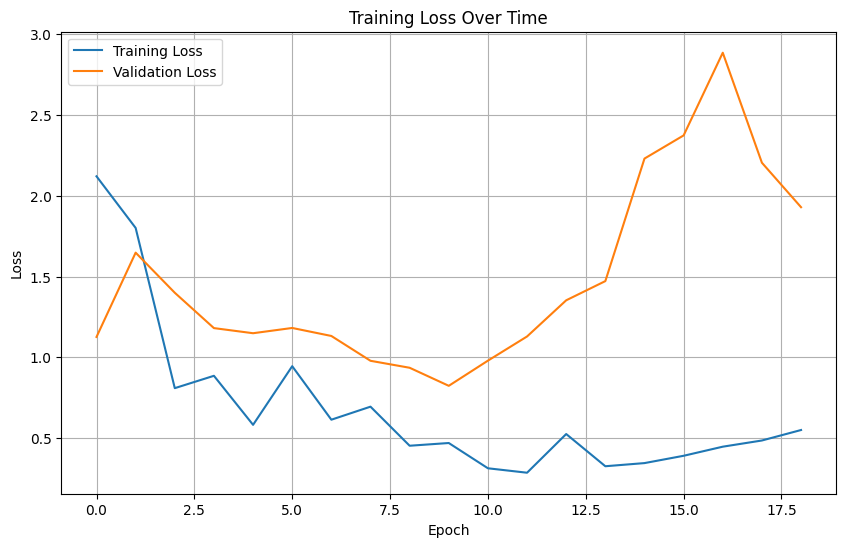

In [22]:
import matplotlib.pyplot as plt

train_loss = history["train_loss"]
val_loss = history["val_loss"]
plt.figure(figsize=(10, 6))
plt.plot(train_loss, label='Training Loss')
plt.plot(val_loss, label='Validation Loss')
plt.title('Training Loss Over Time')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()
plt.grid(True)
plt.show()
